# Semi-gradient n-step TD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

## Review
Weights are updated as follows:
$$
\begin{align}
    \mathbf{w}_{t+1} &= \mathbf{w}_t + \frac{1}{2}\alpha \nabla \overline{VE}(\mathbf{w})\\
    \mathbf{w}_{t+1} &= \mathbf{w}_t + \alpha \big(U_t - \hat{v}(x, \mathbf{w_t})\big) \nabla \hat{v}(x, \mathbf{w_t})
\end{align}
$$

The return $U_t$ bootstraps for $n$-steps using the approximator function to compute the return. However, we DO NOT compute the gradient of $U_t$, since it is our target. That is why we call the algorithm "semi-gradient"

$n$-step bootstrapping is as follows:
$$
\begin{align}
    U_t = G_{t:t+n} + \gamma^{t+n} \hat{v}(x_{t+n}, \mathbf{w})
\end{align}
$$

In [2]:
class RandomWalk(gym.Env):
    def __init__(self, states:int):
        super(RandomWalk, self).__init__()

        self.states = states
        self.current_state = None

        self.observation_space = gym.spaces.Box(low=0, high=states, shape=(1,), dtype=np.int32)
        self.action_space = gym.spaces.Discrete(2)

        self.action_translation = [-1, 1]

    def reset(self, seed:int=None):
        self.current_state = self.states // 2
        return {'state':self.current_state}

    def is_terminated(self):
        return self.current_state in [0, self.states - 1]

    def step(self, action:int):
        if action >= len(self.action_translation):
            raise ValueError("Action is undefined!")

        if self.current_state is None:
            raise ValueError("Please reset the environment first")

        if self.is_terminated():
            return {'state': self.current_state, 'reward': 0, 'terminated':True}

        self.current_state += self.action_translation[action] * np.random.randint(1, 101)
        self.current_state = np.clip(self.current_state, 0, self.states - 1)

        reward = 0
        if self.is_terminated():
            reward = 1 if self.current_state == self.states - 1 else -1
        return {'state': self.current_state, 'reward': reward, 'terminated':self.is_terminated()}

In [3]:
def X(state:int, groups:int, num_states:int) -> int:
    max_entry_per_group = num_states // groups
    return state // max_entry_per_group

In [4]:
def v_hat(x:int, w:np.ndarray) -> float:
    return w[x]

In [5]:
def gradient_v_hat(x:int, num_features:int):
    grad = np.zeros(num_features, dtype='float32')
    grad[x] = 1.0
    return grad

In [6]:
def n_step_semi_gradient_td(
    env: RandomWalk,
    policy,
    num_states:int,
    num_features:int,
    num_episodes:int=1,
    n:int=1,
    gamma:float=1.0,
    alpha:float=0.1
):
    w = np.zeros(num_features)
    compute_features = lambda state: X(state, num_features, num_states)
    memory = [{} for _ in range(n + 1)]
    with tqdm(list(range(num_episodes))) as pbar:
        for i in pbar:
            state = int(env.reset()['state'])
            T = np.inf
            tau = 0
            t = 0
            memory[t % (n + 1)]['state'] = state

            while tau < T - 1:
                if t < T:
                    state = memory[t % (n + 1)]['state']
                    action = policy(state)
                    memory[t % (n + 1)]['action'] = action

                    feedback = env.step(action)
                    memory[(t + 1) % (n + 1)]['state'] = int(feedback['state'])
                    memory[(t + 1) % (n + 1)]['reward'] = feedback['reward']
                    terminated = feedback['terminated']

                    if terminated:
                        T = t + 1
                
                tau = t - n + 1

                if tau >= 0:
                    G = 0
                    for i in reversed(range(tau + 1, min(tau + n + 1, T + 1))):
                        G = gamma * G + memory[i % (n + 1)]['reward']
                    
                    if tau + n < T:
                        feature = compute_features(memory[(tau + n) % (n + 1)]['state'])
                        G += (gamma ** n) * v_hat(feature, w)

                    feature = compute_features(memory[tau % (n + 1)]['state'])
                    w = w + alpha * (G - v_hat(feature, w)) * gradient_v_hat(feature, num_features)
                
                t += 1
    
    return w

In [7]:
env = RandomWalk(1000)
w = n_step_semi_gradient_td(
    env=env,
    policy=lambda state: np.random.choice([0, 1]),
    num_states=1000,
    num_features=10,
    num_episodes=30000,
    n=3,
    gamma=1.0,
    alpha=0.001
)

100%|██████████| 30000/30000 [01:30<00:00, 332.26it/s]


In [8]:
values = []
for state in range(0, 1000):
    feature = X(state, 10, 1001)
    values.append(v_hat(feature, w=w))

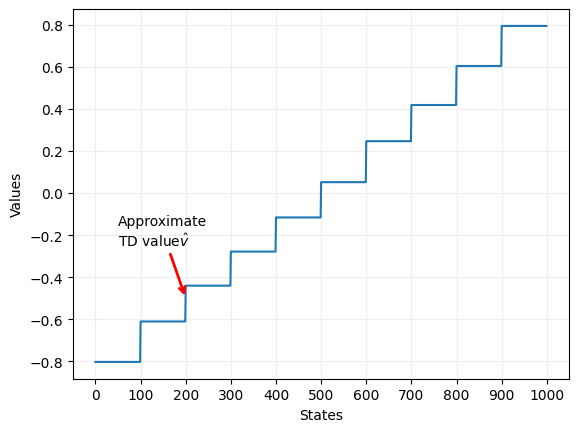

In [9]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(values)
ax.annotate(
    text="Approximate\nTD value" + r"$\hat{v}$",
    xy=(200, -0.5),
    xytext=(50, -0.25),
    arrowprops=dict(
        arrowstyle="->",
        lw=2,
        color='red'
    ),
)
ax.grid(c='#eee')
ax.set_xlabel("States")
ax.set_ylabel("Values");
ax.set_xticks([x * 100 for x in range(11)]);